In [1]:
import random
import math
import time
import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms

## Self-Attention

DCGAN같이 ConvTranspose2d의 연속적인 사용은 국소적인 정보 확대의 연속에 불과. 이미지 전체의 포괄적인 정보를 반영하지 못하는 단점 존재.

CNN은 기본적으로 local neighborhood의 정보만을 처리하기 때문에 long range dependencies (이미지 내에서 서로 멀리 떨어진 지역들)를 처리하는데 있어 비효율적.

`Since the convolution operator has a local receptive field, long range dependencies can only be processed after passing through several convolutional layers. This could prevent learning about long-term dependencies.`

SAGAN은 self-attention 모듈을 GAN에 도입하여 멀리 떨어진 지역들 간의 상관성, 의존성을 효율적으로 모델링함.

커널 크기 최대의 합성곱 역할을 하지만, 해당 커널의 파라미터를 학습시키지 않고 자신과 유사한 특징량을 커널 값으로 하여 계산.

<br/>

**Attention 참고** :

https://github.com/gymoon10/Paper-Review/blob/main/NLP/Attention%20is%20All%20you%20Need%20-%20%EC%84%A4%EB%AA%85%26%EB%85%BC%EB%AC%B8%EC%9D%BD%EA%B8%B0.ipynb

https://github.com/gymoon10/Paper-Review/blob/main/NLP/BERT.md

https://github.com/gymoon10/Paper-Review/blob/main/NLP/NMT_%EC%A0%95%EB%A6%AC.pdf

![image](https://user-images.githubusercontent.com/44194558/148348716-8a2ce77c-1ae9-4607-a041-84ea2a84e365.png)

![image](https://user-images.githubusercontent.com/44194558/148348777-c217fc42-75aa-42a3-a9f6-545930bc13ee.png)

![image](https://user-images.githubusercontent.com/44194558/148348837-c5ded2b8-bfc7-4492-8667-7b061a7c7633.png)



In [8]:
class Self_Attention(nn.Module):

    def __init__(self, in_dim):
        super(Self_Attention, self).__init__()
        
        # Query, Key, Value embedding (채널 별 선형 합을 만드는 1x1 합성곱 이용)
        # 입력에 대한 특징량 변환
        self.query_conv = nn.Conv2d(
            in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)  # Q : 원래 입력의 전치에 대응 / f (위 그림 참고)
        self.key_conv = nn.Conv2d(
            in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)  # K : 원래 입력 x에 대응 / g
        self.value_conv = nn.Conv2d(
            in_channels=in_dim, out_channels=in_dim, kernel_size=1)  # V : Attention map과 곱하는 대상 / h
        
        # Attention map 정규화용 (행 방향)
        self.softmax = nn.Softmax(dim=-2)
        
        # Attention map에 대한 계수 / output = x + gamma * O (Attention map)
        self.gamma = nn.Parameter(torch.zeros(1))  

    def forward(self, x):
        # Input
        X = x  # (B, C, H, W)

        # Q, K embedding
        proj_query = self.query_conv(X).view(X.shape[0], -1, X.shape[2] * X.shape[3])  # (B, C', H, W) -> (B, C', N), N=HxW
        proj_query = proj_query.permute(0, 2, 1)  # 전치
        proj_key = self.key_conv(X).view(X.shape[0], -1, X.shape[2] * X.shape[3])  # (B, C', H, W) -> (B, C', N)
        
        # Attention map 계산 + 정규화
        S = torch.bmm(proj_query, proj_key)  # 배치 별 행렬곱
        
        # Attention score (weight)
        attention_map_T = self.softmax(S)  # (N, N)
        attention_map = attention_map_T.permute(0, 2, 1)  # B_ji (j th region을 생성하는데 i th region이 얼마나 중요한지)

        # Self-Attention map 계산
        proj_value = self.value_conv(x).view(X.shape[0], -1, X.shape[2] * X.shape[3])  # (B, C, N)
        o = torch.bmm(proj_value, attention_map.permute(0, 2, 1))  # Batch 별로 (C, N) x (N, N)
        o = o.view(X.shape[0], X.shape[1], X.shape[2], X.shape[3])  # Self-Attention map (입력 x를 포괄적인 정보를 바탕으로 조정하는 양)
        out = x + self.gamma*o  # 포괄적인 정보를 고려하여 입력 x를 조정

        return out, attention_map

## Generator

 - 전치 합성곱 층에 스펙트럴 정규화를 추가 (마지막 layer 제외)

 - 3-4, 4-last layer 사이에 self attention 모듈 추가


 스펙트럴 정규화는 데이터가 아닌 합성곱 층 등의 네트워크 가중치 파라미터를 표준화. D가 립시츠 연속성 조건을 만족하게 하여 GAN 학습을 용이하게 함.

 **립시츠 연속성** 

 D에 대한 입력 이미지가 아주 조금 변하면 D의 출력 역시 거의 변하지 않아야 한다. (연속성을 확보하지 못하면 입력 이미지가 아주 조금 변해도 D의 출력이 크게 변화하하여 G, D가 제대로 학습하지 못함)

 입력 -> 출력으로 확대 되는 처리가 있을 때 다양한 성분이 확대되는 값 중 최댓값 (고윳값 분해시 최대 고윳값에 대응)을 사용하여 층의 파라미터를 정규화

In [9]:
class Generator(nn.Module):

    def __init__(self, z_dim=20, image_size=64):
        super(Generator, self).__init__()

        self.layer1 = nn.Sequential(
            # Spectral Normalization
            nn.utils.spectral_norm(nn.ConvTranspose2d(z_dim, image_size * 8,
                                                      kernel_size=4, stride=1)),
            nn.BatchNorm2d(image_size * 8),
            nn.ReLU(inplace=True))

        self.layer2 = nn.Sequential(
            nn.utils.spectral_norm(nn.ConvTranspose2d(image_size * 8, image_size * 4,
                                                      kernel_size=4, stride=2, padding=1)),
            nn.BatchNorm2d(image_size * 4),
            nn.ReLU(inplace=True))

        self.layer3 = nn.Sequential(
            nn.utils.spectral_norm(nn.ConvTranspose2d(image_size * 4, image_size * 2,
                                                      kernel_size=4, stride=2, padding=1)),
            nn.BatchNorm2d(image_size * 2),
            nn.ReLU(inplace=True))

        # Self-Attention
        self.self_attntion1 = Self_Attention(in_dim=image_size * 2)

        self.layer4 = nn.Sequential(
            nn.utils.spectral_norm(nn.ConvTranspose2d(image_size * 2, image_size,
                                                      kernel_size=4, stride=2, padding=1)),
            nn.BatchNorm2d(image_size),
            nn.ReLU(inplace=True))

        self.self_attntion2 = Self_Attention(in_dim=image_size)

        self.last = nn.Sequential(
            nn.ConvTranspose2d(image_size, 1, kernel_size=4,
                               stride=2, padding=1),
            nn.Tanh())

    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)
        out = self.layer3(out)
        out, attention_map1 = self.self_attntion1(out)
        out = self.layer4(out)
        out, attention_map2 = self.self_attntion2(out)
        out = self.last(out)

        return out, attention_map1, attention_map2

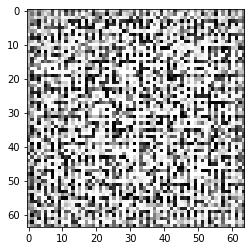

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

G = Generator(z_dim=20, image_size=64)

input_z = torch.randn(1, 20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)

fake_images, attention_map1, attention_map2 = G(input_z)

img_transformed = fake_images[0][0].detach().numpy()
plt.imshow(img_transformed, 'gray')
plt.show()

## Discriminator

In [11]:
class Discriminator(nn.Module):

    def __init__(self, z_dim=20, image_size=64):
        super(Discriminator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(1, image_size, kernel_size=4,
                                             stride=2, padding=1)),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer2 = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(image_size, image_size*2, kernel_size=4,
                                             stride=2, padding=1)),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer3 = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(image_size*2, image_size*4, kernel_size=4,
                                             stride=2, padding=1)),
            nn.LeakyReLU(0.1, inplace=True))

        self.self_attntion1 = Self_Attention(in_dim=image_size*4)

        self.layer4 = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(image_size*4, image_size*8, kernel_size=4,
                                             stride=2, padding=1)),
            nn.LeakyReLU(0.1, inplace=True))

        self.self_attntion2 = Self_Attention(in_dim=image_size*8)

        self.last = nn.Conv2d(image_size*8, 1, kernel_size=4, stride=1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out, attention_map1 = self.self_attntion1(out)
        out = self.layer4(out)
        out, attention_map2 = self.self_attntion2(out)
        out = self.last(out)

        return out, attention_map1, attention_map2

In [12]:
D = Discriminator(z_dim=20, image_size=64)

input_z = torch.randn(1, 20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)

fake_images, _, _ = G(input_z)

d_out, attention_map1, attention_map2 = D(fake_images)

print(nn.Sigmoid()(d_out))

tensor([[[[0.4835]]]], grad_fn=<SigmoidBackward0>)


## Data

In [13]:
! pip install scikit-learn==0.22.1

     |████████████████████████████████| 7.0 MB 4.9 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.1
    Uninstalling scikit-learn-1.0.1:
      Successfully uninstalled scikit-learn-1.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.8.1 requires scikit-learn>=0.24, but you have scikit-learn 0.22.1 which is incompatible.


In [14]:
import os
import urllib.request
import zipfile
import tarfile

import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import numpy as np

from sklearn.datasets import fetch_openml

In [15]:
data_dir = "./data/"
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

In [16]:
mnist = fetch_openml('mnist_784', version=1, data_home="./data/")  

X = mnist.data
y = mnist.target

In [17]:
data_dir_path = "./data/img_78/"
if not os.path.exists(data_dir_path):
    os.mkdir(data_dir_path)

count7 = 0
count8 = 0
max_num = 200 

for i in range(len(X)):
    # 7
    if (y[i] is "7") and (count7 < max_num):
        file_path = "./data/img_78/img_7_" + str(count7) + ".jpg"
        im_f = (X[i].reshape(28, 28)) 
        pil_img_f = Image.fromarray(im_f.astype(np.uint8))  # 화상을 PIL으로
        pil_img_f = pil_img_f.resize((64, 64), Image.BICUBIC)  # 64×64로 확대
        pil_img_f.save(file_path)  # 저장
        count7 += 1 
    
    # 8
    if (y[i] is "8") and (count8 < max_num):
        file_path = "./data/img_78/img_8_" + str(count8) + ".jpg"
        im_f = (X[i].reshape(28, 28))
        pil_img_f = Image.fromarray(im_f.astype(np.uint8))  # 화상을 PIL으로
        pil_img_f = pil_img_f.resize((64, 64), Image.BICUBIC)  # 64×64로 확대
        pil_img_f.save(file_path)  # 저장
        count8 += 1 

## DataLoader

In [18]:
def make_datapath_list():

    train_img_list = list()  # 이미지 파일 경로를 저장

    for img_idx in range(200):
        img_path = "./data/img_78/img_7_" + str(img_idx) + '.jpg'
        train_img_list.append(img_path)

        img_path = "./data/img_78/img_8_" + str(img_idx) + '.jpg'
        train_img_list.append(img_path)

    return train_img_list

In [19]:
# 전처리 클래스
class ImageTransform():

    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

    def __call__(self, img):
        return self.data_transform(img)

In [20]:
# 전처리한 이미지의 텐서 형식 데이터 획득
class GAN_Img_Dataset(data.Dataset):

    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        img_path = self.file_list[index]
        img = Image.open(img_path) 

        img_transformed = self.transform(img)

        return img_transformed

In [21]:
train_img_list = make_datapath_list()

mean = (0.5,)
std = (0.5,)
train_dataset = GAN_Img_Dataset(
    file_list=train_img_list, transform=ImageTransform(mean, std))

batch_size = 64

# Data Loader
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

batch_iterator = iter(train_dataloader)  # 반복자로 변환
imges = next(batch_iterator)  # 1번째 요소를 꺼냄
print(imges.size())  

torch.Size([64, 1, 64, 64])


## Train

In [23]:
def train_model(G, D, dataloader, num_epochs):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("사용 장치: ", device)
    
    # Optimizer
    g_lr, d_lr = 0.0001, 0.0004
    beta1, beta2 = 0.0, 0.9
    g_optimizer = torch.optim.Adam(G.parameters(), g_lr, [beta1, beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), d_lr, [beta1, beta2])

    criterion = nn.BCEWithLogitsLoss(reduction='mean')
    
    # Parameter
    z_dim = 20
    mini_batch_size = 64

    G.to(device)
    D.to(device)

    G.train()  
    D.train()

    torch.backends.cudnn.benchmark = True

    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size

    iteration = 1
    logs = []

    for epoch in range(num_epochs):

        t_epoch_start = time.time()
        epoch_g_loss = 0.0 
        epoch_d_loss = 0.0 

        print('-------------')
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-------------')
        print('(train)')

        # DataLoader에서 minibatch씩 꺼냄
        for imges in dataloader:

            # --------------------
            # 1. Discriminator 학습
            # --------------------
            if imges.size()[0] == 1:
                continue

            imges = imges.to(device)
            mini_batch_size = imges.size()[0]

            label_real = torch.full((mini_batch_size,), 1).to(device)
            label_fake = torch.full((mini_batch_size,), 0).to(device)
            
            # 진짜 이미지 판별
            d_out_real, _, _ = D(imges)
            
            # 가짜 이미지 생성 & 판별
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images, _, _ = G(input_z)
            d_out_fake, _, _ = D(fake_images)

            # d_loss_real = criterion(d_out_real.view(-1), label_real)
            # d_loss_fake = criterion(d_out_fake.view(-1), label_fake)

            d_loss_real = torch.nn.ReLU()(1.0 - d_out_real).mean()
            # 오차 d_out_real이 1이상에서 오차 0이 된다. d_out_real>1에서,
            # 1.0 - d_out_real가 음수이면 ReLU로 0으로 한다

            d_loss_fake = torch.nn.ReLU()(1.0 + d_out_fake).mean()
            # 오차 d_out_fake가 -1 이하이면 오차 0이 된다. d_out_fake<-1에서,
            # 1.0 + d_out_real가 음수이면 ReLU로 0으로 한다

            d_loss = d_loss_real + d_loss_fake

            # 역전파
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()

            d_loss.backward()
            d_optimizer.step()

            # --------------------
            # 2. Generator 학습
            # --------------------
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images, _, _ = G(input_z)
            d_out_fake, _, _ = D(fake_images)

            # 오차를 계산→hinge version of the adversarial loss로 변경
            #g_loss = criterion(d_out_fake.view(-1), label_real)
            g_loss = - d_out_fake.mean()

            # 역전파
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()
            
            # --------------------
            # 3. 기록
            # --------------------
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            iteration += 1

        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_D_Loss:{:.4f} ||Epoch_G_Loss:{:.4f}'.format(
            epoch, epoch_d_loss/batch_size, epoch_g_loss/batch_size))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

    # print("총 반복 횟수: ", iteration)

    return G, D

In [24]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # Conv2d과 ConvTranspose2d 초기화
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        # BatchNorm2d 초기화
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# 초기화 실시
G.apply(weights_init)
D.apply(weights_init)

print("네트워크 초기화 완료")

네트워크 초기화 완료


In [25]:
num_epochs = 300
G_update, D_update = train_model(G, D, dataloader=train_dataloader, num_epochs=num_epochs)


사용 장치:  cpu
-------------
Epoch 0/300
-------------
(train)


KeyboardInterrupt: ignored